
# Shrinkage covariance estimation: LedoitWolf vs OAS and max-likelihood

When working with covariance estimation, the usual approach is to use
a maximum likelihood estimator, such as the
:class:`~sklearn.covariance.EmpiricalCovariance`. It is unbiased, i.e. it
converges to the true (population) covariance when given many
observations. However, it can also be beneficial to regularize it, in
order to reduce its variance; this, in turn, introduces some bias. This
example illustrates the simple regularization used in
`shrunk_covariance` estimators. In particular, it focuses on how to
set the amount of regularization, i.e. how to choose the bias-variance
trade-off.


## Generate sample data



In [1]:
import numpy as np

n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

### Shrinkage on Covariance Matrices of Multiple Features and Samples

#### Empirical Covariance Matrix
The empirical covariance matrix is an estimate of the true covariance matrix based on the observed data. For a dataset with $n$ samples and $p$ features, the empirical covariance matrix $S$ is calculated as:
$$
S = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})(x_i - \bar{x})^T
$$
where $x_i$ represents the $i$-th sample and $\bar{x}$ is the mean vector of the samples.

#### Shrinkage
Shrinkage is a technique used to improve the estimation of the covariance matrix by pulling the empirical covariance matrix towards a target structure, such as the identity matrix or a diagonal matrix. This reduces the estimator's variance, leading to more robust and reliable covariance estimates, especially in high-dimensional settings. The shrinkage estimator $\hat{\Sigma}$ is defined as:
$$
\hat{\Sigma} = (1 - \lambda) S + \lambda T
$$
where $S$ is the empirical covariance matrix, $T$ is the target matrix, and $\lambda \in [0, 1]$ is the shrinkage coefficient.

#### Mathematical Explanation of Variance Reduction
Shrinkage reduces the variance of the estimator by averaging the empirical covariance with the target matrix. The variance of the empirical covariance matrix $S$ can be high, especially when the sample size $n$ is small relative to the number of features $p$. By introducing the shrinkage target $T$, we obtain a more stable estimate. The shrinkage coefficient $\lambda$ controls the trade-off between bias and variance:
- When $\lambda = 0$, $\hat{\Sigma} = S$, which has low bias but high variance.
- When $\lambda = 1$, $\hat{\Sigma} = T$, which has high bias but low variance.

The optimal value of $\lambda$ is often chosen using cross-validation or other model selection criteria to balance bias and variance effectively.

#### Practical Application
In practice, the shrinkage estimator is used to improve the performance of various statistical and machine learning models, such as linear discriminant analysis (LDA) or portfolio optimization in finance, where accurate covariance matrix estimation is crucial.



## Compute the likelihood on test data



In [2]:
from scipy import linalg

from sklearn.covariance import ShrunkCovariance, empirical_covariance, log_likelihood

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [
    -ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test) for s in shrinkages
]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

### Log Likelihood between a True Covariance Matrix and an Estimator

#### Concept of Log Likelihood
In statistics, the log likelihood measures how well a parameterized statistical model explains observed data. When comparing covariance matrices, the log likelihood can be used to assess how well an estimated covariance matrix approximates the true covariance matrix.

#### Mathematical Formulation
Given:
- $\Sigma$ as the true covariance matrix
- $\hat{\Sigma}$ as the estimated covariance matrix

The log likelihood $L(\hat{\Sigma}|\Sigma)$ of $\hat{\Sigma}$ given $\Sigma$ can be computed as:
$$
L(\hat{\Sigma}|\Sigma) = -\frac{1}{2} \left( \log \det(\Sigma) + \text{trace}(\Sigma^{-1} \hat{\Sigma}) + p \log(2\pi) \right)
$$
where $\det(\Sigma)$ is the determinant of $\Sigma$, $\text{trace}(\Sigma^{-1} \hat{\Sigma})$ is the trace of the product of the inverse of $\Sigma$ and $\hat{\Sigma}$, and $p$ is the number of features.

#### Example Calculation
For our scenario:
- $\Sigma$ is the real covariance matrix
- $\hat{\Sigma}$ is the empirical covariance matrix $S$

The negative log likelihood $\mathcal{L}$ is calculated as:
$$
\mathcal{L} = -\log L(S|\Sigma) = \frac{1}{2} \left( \log \det(\Sigma) + \text{trace}(\Sigma^{-1} S) + p \log(2\pi) \right)
$$

#### Code Example Explanation
The code `loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))` computes the negative log likelihood of the empirical covariance matrix $S$ given the true covariance matrix $\Sigma$:

1. **Compute Empirical Covariance Matrix $S$**:
    $$ S = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})(x_i - \bar{x})^T $$
    
2. **Compute the Inverse of True Covariance Matrix $\ Sigma^{-1} $**:
    $\ Sigma^{-1} = \text{linalg.inv(real_cov)} $
    
3. **Calculate Log Determinant of $\Sigma$**:
    $$ \log \det(\Sigma) $$
    
4. **Calculate Trace of the Product $\Sigma^{-1} S$**:
    $$ \text{trace}(\Sigma^{-1} S) $$
    
5. **Combine Results to Get Log Likelihood**:
    $$ L(S|\Sigma) = -\frac{1}{2} \left( \log \det(\Sigma) + \text{trace}(\Sigma^{-1} S) + p \log(2\pi) \right) $$

6. **Return Negative Log Likelihood**:
    $$ \mathcal{L} = -L(S|\Sigma) $$

#### Intuition
- A higher log likelihood indicates a better fit of the estimated covariance matrix to the true covariance matrix.
- The negative log likelihood provides a cost metric, where lower values indicate a better approximation of the true covariance structure by the estimated matrix.


## Compare different approaches to setting the regularization parameter

Here we compare 3 approaches:

* Setting the parameter by cross-validating the likelihood on three folds
  according to a grid of potential shrinkage parameters.

* A close formula proposed by Ledoit and Wolf to compute
  the asymptotically optimal regularization parameter (minimizing a MSE
  criterion), yielding the :class:`~sklearn.covariance.LedoitWolf`
  covariance estimate.

* An improvement of the Ledoit-Wolf shrinkage, the
  :class:`~sklearn.covariance.OAS`, proposed by Chen et al. Its
  convergence is significantly better under the assumption that the data
  are Gaussian, in particular for small samples.



### Optimal Shrinkage and Covariance Estimation with OAS and LedoitWolf

#### Overview
This section explains how to estimate the optimal shrinkage coefficient for covariance matrices using various techniques provided by `sklearn.covariance` and how to assess their performance using log likelihood. The focus is on two specific methods: Ledoit-Wolf and Oracle Approximating Shrinkage (OAS).

#### Shrinkage Estimation
Shrinkage is a technique to improve the estimation of covariance matrices, especially in high-dimensional settings. It involves combining the empirical covariance matrix with a structured target matrix to reduce estimation variance.

#### GridSearch for Shrinkage Coefficient
The `GridSearchCV` method is used to find the optimal shrinkage coefficient by performing cross-validation over a specified range of shrinkage values:
$$
\text{GridSearchCV}( \text{ShrunkCovariance}(), \{ \text{"shrinkage"}: \text{shrinkages} \} )
$$
- `ShrunkCovariance()`: A covariance estimator with shrinkage.
- `tuned_parameters`: A dictionary specifying the range of shrinkage coefficients to search.
- `GridSearchCV`: Performs cross-validation to find the best shrinkage coefficient.

#### Ledoit-Wolf Estimator
The Ledoit-Wolf estimator provides an optimal shrinkage coefficient that minimizes the mean squared error between the estimated and true covariance matrices:
$$
\text{LedoitWolf}()
$$
- `LedoitWolf()`: An estimator that automatically determines the optimal shrinkage coefficient.

#### Oracle Approximating Shrinkage (OAS)
OAS is another method for estimating the optimal shrinkage coefficient. It aims to minimize the mean squared error but assumes a different prior distribution than Ledoit-Wolf:
$$
\text{OAS}()
$$
- `OAS()`: An estimator that determines the optimal shrinkage coefficient under the assumption of a specific prior.

#### Mathematical Formulation
The covariance matrix $\Sigma$ is estimated using a combination of the empirical covariance matrix $S$ and a target matrix $T$:
$$
\hat{\Sigma} = (1 - \lambda) S + \lambda T
$$
where $\lambda$ is the shrinkage coefficient.

#### Log Likelihood Calculation
The log likelihood of the data given the estimated covariance matrix $\hat{\Sigma}$ is computed as:
$$
L(\hat{\Sigma}|\Sigma) = -\frac{1}{2} \left( \log \det(\Sigma) + \text{trace}(\Sigma^{-1} \hat{\Sigma}) + p \log(2\pi) \right)
$$
where $\Sigma$ is the true covariance matrix, $\hat{\Sigma}$ is the estimated covariance matrix, and $p$ is the number of features.

#### Interpretation
- **GridSearchCV**: Helps in finding the best shrinkage coefficient by evaluating multiple candidates.
- **Ledoit-Wolf**: Provides a robust and widely-used method for covariance estimation with minimal assumptions.
- **OAS**: Offers an alternative that can be more effective under certain prior assumptions.

Both Ledoit-Wolf and OAS improve the stability and accuracy of covariance matrix estimation, leading to better performance in downstream tasks such as classification and clustering.


In [3]:
from sklearn.covariance import OAS, LedoitWolf
from sklearn.model_selection import GridSearchCV

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

The `LedoitWolf` estimator is used to fit the covariance model to the training data. The `.score` method computes the log-likelihood of the test data under the model.

The log-likelihood is a measure of how well the model explains the data, and is given by:

$$
\log \det (\Sigma^{-1}) - \text{trace}(S \Sigma^{-1})
$$

where $\Sigma$ is the estimated covariance matrix from `LedoitWolf`, and $S$ is the empirical covariance of $X_{\text{test}}$.


## Plot results


To quantify estimation error, we plot the likelihood of unseen data for
different values of the shrinkage parameter. We also show the choices by
cross-validation, or with the LedoitWolf and OAS estimates.



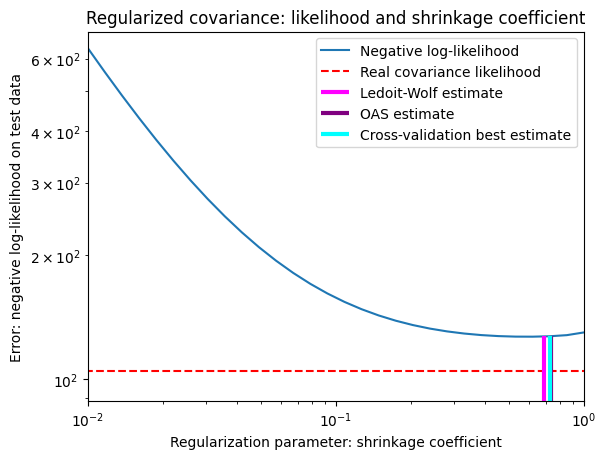

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel("Regularization parameter: shrinkage coefficient")
plt.ylabel("Error: negative log-likelihood on test data")
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], "--r", label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10.0 * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(
    lw.shrinkage_,
    ymin,
    -loglik_lw,
    color="magenta",
    linewidth=3,
    label="Ledoit-Wolf estimate",
)
# OAS likelihood
plt.vlines(
    oa.shrinkage_, ymin, -loglik_oa, color="purple", linewidth=3, label="OAS estimate"
)
# best CV estimator likelihood
plt.vlines(
    cv.best_estimator_.shrinkage,
    ymin,
    -cv.best_estimator_.score(X_test),
    color="cyan",
    linewidth=3,
    label="Cross-validation best estimate",
)

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The maximum likelihood estimate corresponds to no shrinkage,
   and thus performs poorly. The Ledoit-Wolf estimate performs really well,
   as it is close to the optimal and is not computationally costly. In this
   example, the OAS estimate is a bit further away. Interestingly, both
   approaches outperform cross-validation, which is significantly most
   computationally costly.</p></div>

